In [1304]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
import warnings
import time
import itertools
warnings.filterwarnings("ignore")

PCOS = pd.read_csv("PCOS.csv")

In [1305]:
def confusion_matrix_train(model, cutoff=0.5):
# Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))
    
def confusion_matrix_test(data,actual_values,model,cutoff=0.3):
    #Predict the values using the Logit model
    pred_values = model.predict(data)
    # Specify the bins
    bins=np.array([0,cutoff,1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    # Return the confusion matrix and the accuracy
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))

# Data Cleaning

In [1306]:
PCOS = PCOS.rename(columns={"Sl. No":"num", "Patient File No.": "patient", "PCOS (Y/N)":"PCOS", "Age (yrs)": "age", 
       'Weight (Kg)' : "weight", 'Height(Cm)':"height", "Blood Group": "blood_group",'Pulse rate(bpm)': "pulse_rate",
       'RR (breaths/min)': "RR", 'Hb(g/dl)': "hb", 'Cycle(R/I)': "cycle_ri", 'Cycle length(days)': "cycle",
       'Marraige Status (Yrs)': "marriage_years", 'Pregnant(Y/N)': "pregnant", 'No. of aborptions': "number_abortions",
       '  I   beta-HCG(mIU/mL)': "I", 'II    beta-HCG(mIU/mL)': "II", 'FSH(mIU/mL)': "FAH",
       'LH(mIU/mL)': "LH", 'FSH/LH': "FSH_LH", 'Hip(inch)': "hip", 'Waist(inch)': "waist", 'Waist:Hip Ratio': "hw_ratio",
       'TSH (mIU/L)': "TSH", 'AMH(ng/mL)': "AMH", 'PRL(ng/mL)':"PRL", 'Vit D3 (ng/mL)': "vit",
       'PRG(ng/mL)':"prg", 'RBS(mg/dl)':"rbs", 'Weight gain(Y/N)':"weight_gain", 'hair growth(Y/N)':"hair_growth",
       'Skin darkening (Y/N)': "skin_dark", 'Hair loss(Y/N)': "hair_loss", 'Pimples(Y/N)': "pimples",
       'Fast food (Y/N)': "fast_food", 'Reg.Exercise(Y/N)':"regular_exercise", 'BP _Systolic (mmHg)':"bp_systolic",
       'BP _Diastolic (mmHg)': "bp_distolic", 'Follicle No. (L)':"follicle_L", 'Follicle No. (R)': "follicle_R",
       'Avg. F size (L) (mm)':"ave_size_L", 'Avg. F size (R) (mm)':"ave_size_R", 'Endometrium (mm)':"endometrium", 'Unnamed: 44':"NA"})


In [1307]:
PCOS = PCOS.drop(columns = {'NA'})
PCOS["hw_ratio"] = PCOS["hip"]/PCOS["waist"]
PCOS["height"] = PCOS["height"]/100
PCOS["BMI"] = PCOS["weight"]/np.square(PCOS["height"])
PCOS.isnull().sum()

num                 0
patient             0
PCOS                0
age                 0
weight              0
height              0
BMI                 0
blood_group         0
pulse_rate          0
RR                  0
hb                  0
cycle_ri            0
cycle               0
marriage_years      1
pregnant            0
number_abortions    0
I                   0
II                  0
FAH                 0
LH                  0
FSH_LH              0
hip                 0
waist               0
hw_ratio            0
TSH                 0
AMH                 0
PRL                 0
vit                 0
prg                 0
rbs                 0
weight_gain         0
hair_growth         0
skin_dark           0
hair_loss           0
pimples             0
fast_food           1
regular_exercise    0
bp_systolic         0
bp_distolic         0
follicle_L          0
follicle_R          0
ave_size_L          0
ave_size_R          0
endometrium         0
dtype: int64

In [1308]:
PCOS = PCOS[~((PCOS['marriage_years'].isnull()) | (PCOS['fast_food'].isnull()))]
PCOS["PCOS"].value_counts()

0    363
1    176
Name: PCOS, dtype: int64

# Create train data

In [1309]:
train = PCOS

In [1310]:
train.head()

,num,patient,PCOS,age,weight,height,BMI,blood_group,pulse_rate,RR,...,pimples,fast_food,regular_exercise,bp_systolic,bp_distolic,follicle_L,follicle_R,ave_size_L,ave_size_R,endometrium
0,1,1,0,28,44.6,1.520,19.304017,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,1.615,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,1.650,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,1.480,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,1.610,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


# Modified Forward Selection: reversed SMOTE & cleaning + test on more predictors (results: better performance on Test)

In [1311]:
count_class_0, count_class_1 = PCOS.PCOS.value_counts()

# Divide by class
df_class_0 = PCOS[PCOS['PCOS'] == 0] #majority class
df_class_1 = PCOS[PCOS['PCOS'] == 1] #minority class

# Sample Majority class (y=0, to have same number of records as minority calls (y=1)
df_class_0_under = df_class_0.sample(count_class_1)
# join the dataframes containing y=1 and y=0
df_test_under = pd.concat([df_class_0_under, df_class_1])

In [1312]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.PCOS.value_counts())
PCOS = df_test_over
PCOS.shape

Random over-sampling:
0    363
1    363
Name: PCOS, dtype: int64


(726, 44)

# Create Test data

In [1313]:
test = PCOS

In [1314]:
test.shape

(726, 44)

## Forward Selection

In [1315]:
X = train[['age', "height", "weight", 'BMI', 'blood_group', 'pulse_rate', 'RR', 'hb',
           'cycle_ri', 'cycle', 'marriage_years', 'pregnant', 'number_abortions', 
           'hw_ratio', 'weight_gain', 
           'hair_growth', 'skin_dark', 'hair_loss',
           'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
           'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
           'endometrium']]


In [1316]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('PCOS~' + '+'.join(predictor_subset), data = train).fit()
    llr = model.llr
    return {"model":model, "llr":llr}
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[abs(models['llr']).argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['llr'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
def forward_selection():
    models_best = pd.DataFrame(columns=["llr", "model"])
    
    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [1317]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.616374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.630979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613564
  

Optimization terminated successfully.
         Current function value: 0.314603
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311099
         Iterations 7
Processed  26 models on 3 predictors in 0.425886869430542 seconds.
Optimization terminated successfully.
         Current function value: 0.268854
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274066
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.273869
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.273724
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.273731
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.271126
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274067
         Iterations 8
Optimization te

Optimization terminated successfully.
         Current function value: 0.226976
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226714
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.227069
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.227592
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226870
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.224500
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226970
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.227928
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225033
         Iterations 8
Processed  22 models on 7 predictors in 0.4063701629638672 seconds.
Optimization t

Optimization terminated successfully.
         Current function value: 0.212262
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212208
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212925
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.213133
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.211900
         Iterations 8
Processed  18 models on 11 predictors in 0.487746000289917 seconds.
Optimization terminated successfully.
         Current function value: 0.210932
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.211098
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.211241
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.211342
         Iterations 8
Optimization t

Optimization terminated successfully.
         Current function value: 0.206128
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206478
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206600
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206627
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206627
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206600
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206211
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206167
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206550
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206458
  

In [1318]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["llr"])
    plt.xlabel('# Predictors')
    plt.ylabel('LLR')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    llr = models_best.apply(lambda row: row[1].llr, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(llr)
    plt.plot(1+llr.argmax(), llr.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted LLR')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

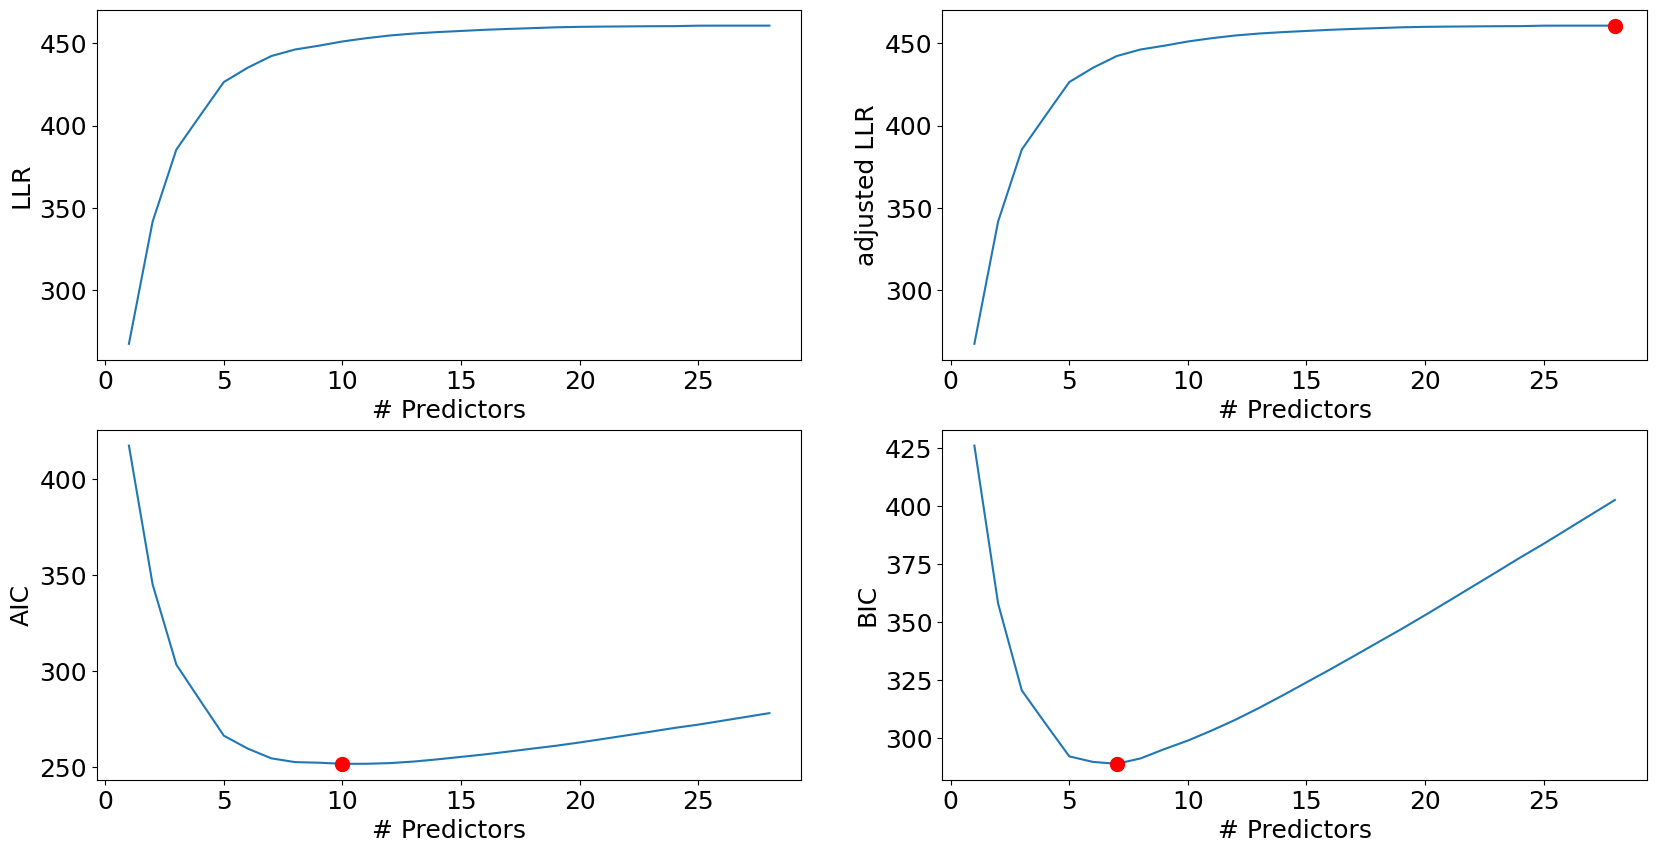

In [1319]:
best_sub_plots()

In [1321]:
best_fwd_reg_model = models_best['model'][10]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  539
Model:                          Logit   Df Residuals:                      528
Method:                           MLE   Df Model:                           10
Date:                Tue, 07 Mar 2023   Pseudo R-squ.:                  0.6625
Time:                        18:16:41   Log-Likelihood:                -114.92
converged:                       True   LL-Null:                       -340.48
Covariance Type:            nonrobust   LLR p-value:                 1.200e-90
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -8.9188      0.917     -9.728      0.000     -10.716      -7.122
follicle_R           0.4396      0.066      6.612      0.000       0.309       0.570
hair_growth          1.6918      0.393      4.301      0.000       0.921       2.463
weight_gain          1.4660      0.373      3.928      0.000       0.735       2.197
skin_dark            1.3001      0.381      3.410      0.001       0.553       2.047
cycle_ri             0.8071      0.189      4.275      0.000       0.437       1.177
pimples              0.9880      0.361      2.739      0.006       0.281       1.695
marriage_years      -0.1146      0.038     -2.992      0.003      -0.190      -0.040
follicle_L           0.1283      0.064      2.012      0.044       0.003       0.253
regular_exercise     0.6517      0.403      1.618      0.106      -0.138       1.441
fast_food            0.5952      0.371      1.606      0.108      -0.131       1.322
====================================================================================
"""

In [1323]:
# confusion_matrix_test(test, test.PCOS, best_interaction_model, cutoff = 0.33)

In [1325]:
forward_subset = train.loc[:,["PCOS", "follicle_R", "weight_gain", "hair_growth", "cycle_ri", "skin_dark", "pimples", "marriage_years", "regular_exercise", "height", "fast_food"]]
forward_subset.head()

,PCOS,follicle_R,weight_gain,hair_growth,cycle_ri,skin_dark,pimples,marriage_years,regular_exercise,height,fast_food
0,0,3,0,0,2,0,0,7.0,0,1.520,1.0
1,0,5,0,0,2,0,0,11.0,0,1.615,0.0
2,1,15,0,0,2,0,1,10.0,0,1.650,1.0
3,0,2,0,0,2,0,0,4.0,0,1.480,0.0
4,0,4,0,0,2,0,0,1.0,0,1.610,0.0


# VIF

In [1328]:
X = train[["follicle_R", "weight_gain", "hair_growth", "cycle_ri", "skin_dark", "pimples", "marriage_years", "regular_exercise", "height", "fast_food"]]
X.columns[1:]
           
           

Index(['weight_gain', 'hair_growth', 'cycle_ri', 'skin_dark', 'pimples',
       'marriage_years', 'regular_exercise', 'height', 'fast_food'],
      dtype='object')

In [1329]:
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)


             feature         VIF
0              const  703.761620
1         follicle_R    1.231180
2        weight_gain    1.341859
3        hair_growth    1.293276
4           cycle_ri    1.168816
5          skin_dark    1.371203
6            pimples    1.153624
7     marriage_years    1.021733
8   regular_exercise    1.033685
9             height    1.018796
10         fast_food    1.324836


Since the VIF for constant is very large. All predictor VIFs are very close to 1, indicating they do not have issues with collinearity. 

# EDA

### Testing if follicle_R needs transformation

In [1330]:
#Binning follicle_R
binned_fol = pd.qcut(train['follicle_R'], 5, retbins=True)
train['fol_binned'] = binned_fol[0]

In [1115]:
#Finding percentage of people having diabetes in each Age bin
fol_data = train.groupby('fol_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
fol_data

,fol_binned,PCOS_percent,nobs
0,"(-0.001, 3.0]",0.039604,101
1,"(3.0, 5.0]",0.090909,77
2,"(5.0, 7.0]",0.288136,59
3,"(7.0, 10.0]",0.564516,62
4,"(10.0, 20.0]",0.822581,62


Text(0.5, 0, 'Follicle Bins')

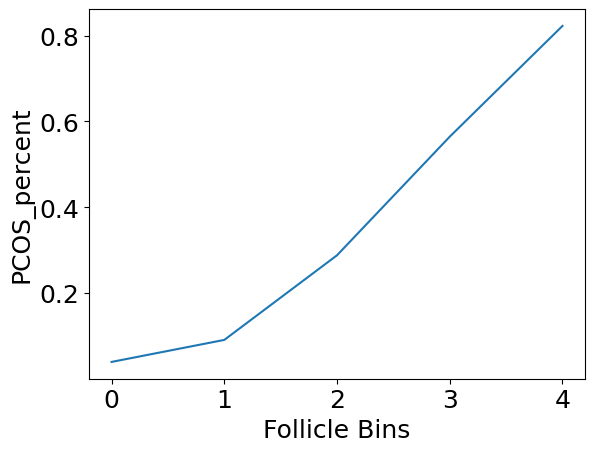

In [1116]:
sns.lineplot(x = fol_data.index, y = fol_data['PCOS_percent'])
plt.xlabel('Follicle Bins')

We observe that the probability of a person having PCOS increases with the number of follicles (collections of fluid developed in ovaries) she has. No transformation needed.

### Binning marriage_years

In [1117]:
logit_model = sm.logit('PCOS~ marriage_years', data = train).fit()

Optimization terminated successfully.
         Current function value: 0.615055
         Iterations 5


Classification accuracy = 46.6292%
False Negative = 30.6452%
False Positive = 65.5172%


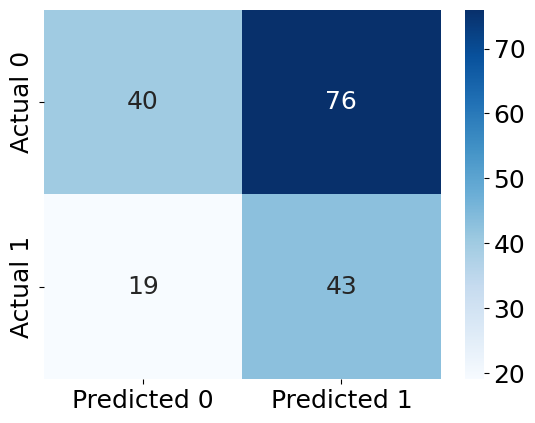

In [1118]:
confusion_matrix_test(test,test.PCOS,logit_model,0.3)

In [1119]:
#Binning marriage_years
binned_mar = pd.qcut(train['marriage_years'], 6, retbins=True)
train['mar_binned'] = binned_mar[0]

In [1120]:
#Finding percentage of people having diabetes in each Age bin
mar_data = train.groupby('mar_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
mar_data

,mar_binned,PCOS_percent,nobs
0,"(-0.001, 3.0]",0.408451,71
1,"(3.0, 5.0]",0.295082,61
2,"(5.0, 7.0]",0.383333,60
3,"(7.0, 9.0]",0.320755,53
4,"(9.0, 12.0]",0.262295,61
5,"(12.0, 30.0]",0.200000,55


Text(0.5, 0, 'marriage_years Bins')

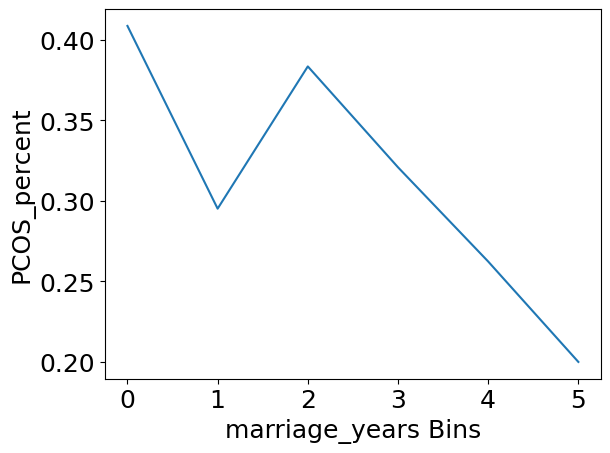

In [1121]:
sns.lineplot(x = mar_data.index, y = mar_data['PCOS_percent'])
plt.xlabel('marriage_years Bins')

Jagged relationship with PCOS percentage, consider transforming using bins

In [1122]:
#Creating a function to bin marriage_years so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_mar = pd.qcut(train['marriage_years'],6,retbins=True)
    bins = binned_mar[1]
    data['mar_binned'] = pd.cut(data['marriage_years'],bins = bins)
    dum = pd.get_dummies(data.mar_binned,drop_first = True)
    dum.columns = ['marriage_years'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [1123]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Optimization terminated successfully.
         Current function value: 0.611746
         Iterations 5


<AxesSubplot:xlabel='marriage_years', ylabel='PCOS'>

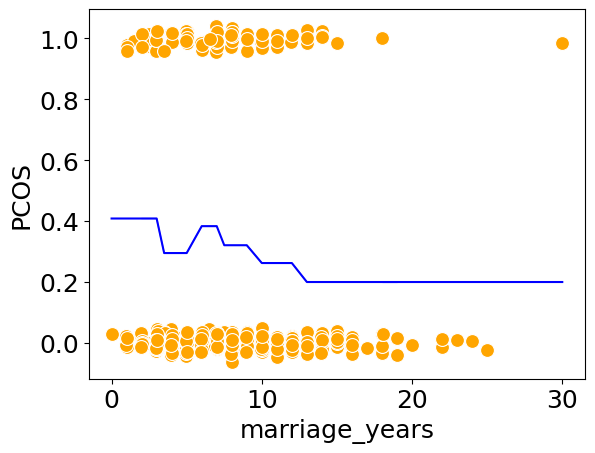

In [1124]:
#Model with binned marriage_years
sns.scatterplot(x = jitter(train.marriage_years,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model2 = sm.logit(formula = 'PCOS~' + '+'.join(['marriage_years'+str(x) for x in range(1,6)]), data = train).fit()
sns.lineplot(x = 'marriage_years', y= logit_model2.predict(train), data = train, color = 'blue')


Classification accuracy = 51.1236%
False Negative = 59.6774%
False Positive = 43.1034%


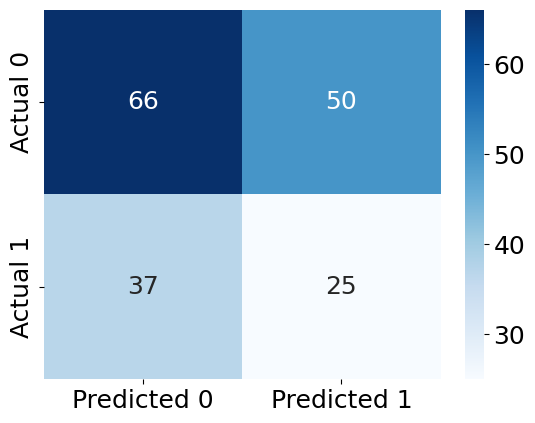

In [1125]:
confusion_matrix_test(test,test.PCOS,logit_model2,0.3)

Accuracy increased, FNR also increased. Transformation not helpful.

### Testing if endometrium needs transformation

In [1126]:
logit_model = sm.logit(formula = 'PCOS~endometrium', data = train).fit()

Optimization terminated successfully.
         Current function value: 0.614478
         Iterations 5


Classification accuracy = 44.3820%
False Negative = 35.4839%
False Positive = 66.3793%


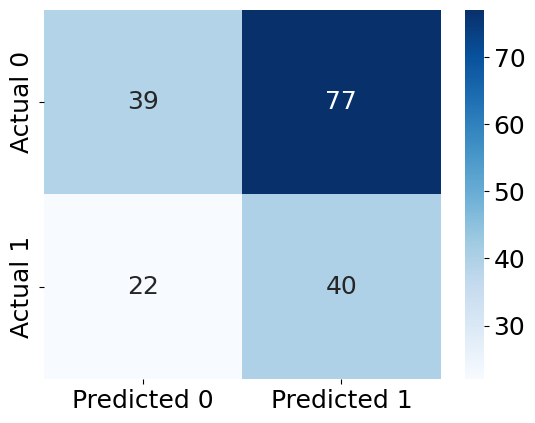

In [1127]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.3)

In [1128]:
#Binning oulse_rate
binned_endo = pd.qcut(train['endometrium'], 6, retbins=True)
train['endo_binned'] = binned_endo[0]

In [1129]:
#Finding percentage of people having diabetes in each Age bin
endo_data = train.groupby('endo_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
endo_data

,endo_binned,PCOS_percent,nobs
0,"(-0.001, 6.3]",0.213115,61
1,"(6.3, 7.5]",0.158730,63
2,"(7.5, 8.5]",0.402778,72
3,"(8.5, 9.0]",0.333333,57
4,"(9.0, 10.0]",0.452830,53
5,"(10.0, 18.0]",0.345455,55


Text(0.5, 0, 'endometrium_bin')

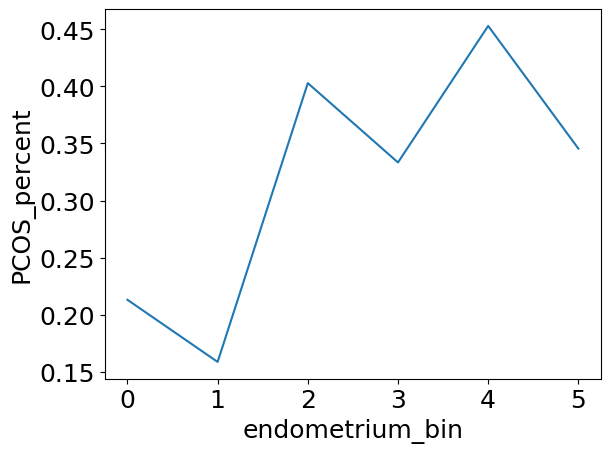

In [1130]:
sns.lineplot(x = endo_data.index, y = endo_data['PCOS_percent'])
plt.xlabel('endometrium_bin')

In [1131]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_endo = pd.qcut(train['endometrium'], 5,retbins=True)
    bins = binned_endo[1]
    data['endo_binned'] = pd.cut(data['endometrium'],bins = bins)
    dum = pd.get_dummies(data.endo_binned,drop_first = True)
    dum.columns = ['endometrium'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [1132]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Optimization terminated successfully.
         Current function value: 0.610863
         Iterations 5


<AxesSubplot:xlabel='endometrium', ylabel='PCOS'>

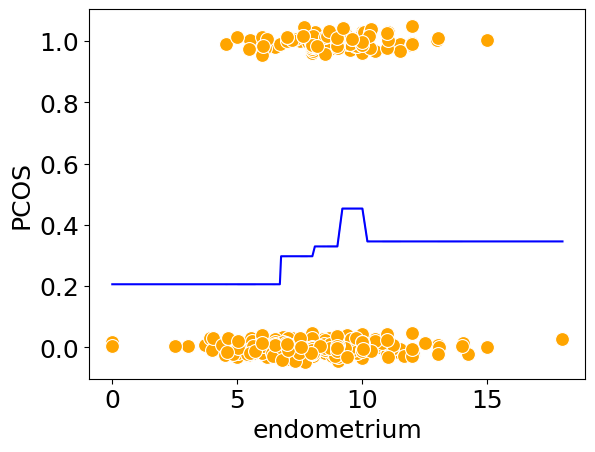

In [1133]:
#Model with binned BMI
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(train.endometrium,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'PCOS~' + '+'.join(['endometrium'+str(x) for x in range(1,5)]), data = train).fit()
sns.lineplot(x = 'endometrium', y= logit_model.predict(train), data = train, color = 'blue') 



Classification accuracy = 46.6292%
False Negative = 38.7097%
False Positive = 61.2069%


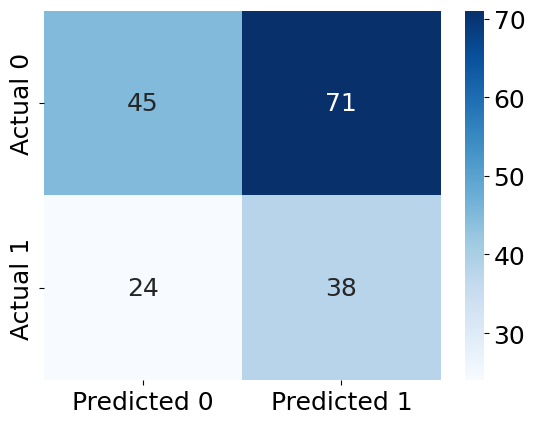

In [1134]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.3)

Accuracy increased, FNR increased. Don't include transformation of endometrium.

### Testing if height needs tranformation

In [1135]:
logit_model = sm.logit(formula = 'PCOS~height', data = train).fit()

Optimization terminated successfully.
         Current function value: 0.623586
         Iterations 5


Classification accuracy = 43.2584%
False Negative = 12.9032%
False Positive = 80.1724%


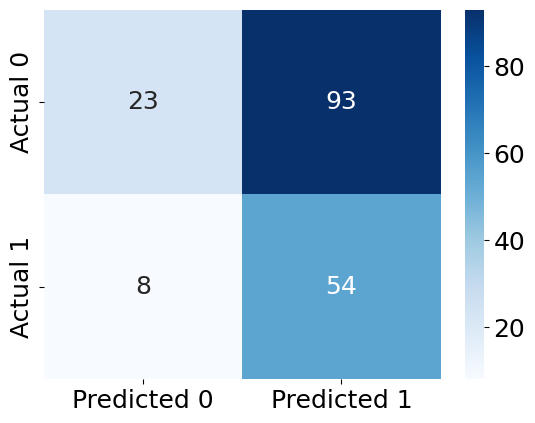

In [1136]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.31)

In [1137]:
#Binning hw_ratio
binned_height = pd.qcut(train['height'], 5, retbins=True)
train['height_binned'] = binned_height[0]

In [1138]:
#Finding percentage of people having diabetes in each Age bin
height_data = train.groupby('height_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
height_data

,height_binned,PCOS_percent,nobs
0,"(1.399, 1.52]",0.303571,112
1,"(1.52, 1.54]",0.375000,40
2,"(1.54, 1.58]",0.318681,91
3,"(1.58, 1.61]",0.307692,52
4,"(1.61, 1.8]",0.303030,66


Text(0.5, 0, 'height_bin')

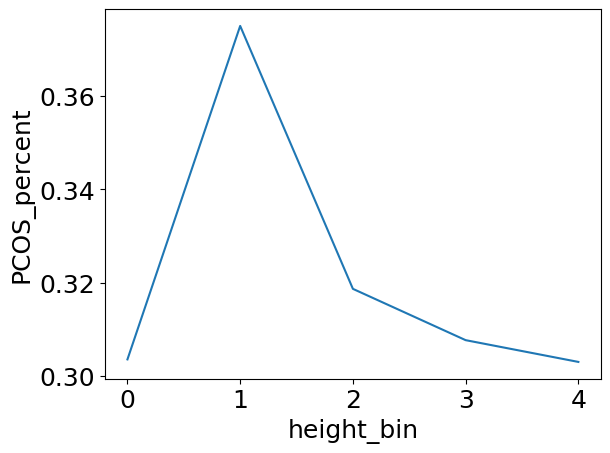

In [1139]:
sns.lineplot(x = height_data.index, y = height_data['PCOS_percent'])
plt.xlabel('height_bin')

In [1140]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_height = pd.qcut(train['height'], 5,retbins=True)
    bins = binned_height[1]
    data['height_binned'] = pd.cut(data['height'],bins = bins)
    dum = pd.get_dummies(data.height_binned,drop_first = True)
    dum.columns = ['height'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [1141]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Optimization terminated successfully.
         Current function value: 0.622578
         Iterations 5


<AxesSubplot:xlabel='height', ylabel='PCOS'>

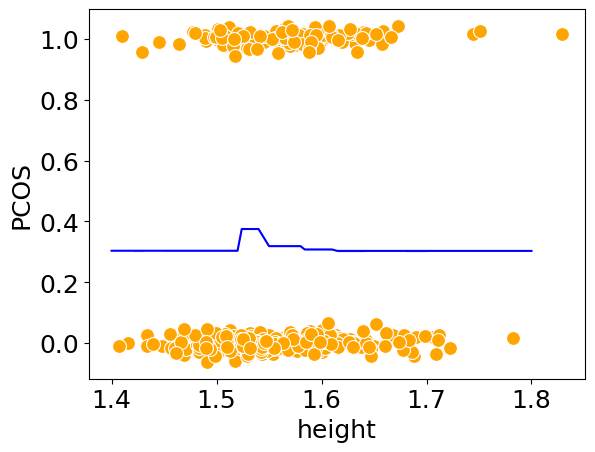

In [1142]:
#Model with binned BMI
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(train.height,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'PCOS~' + '+'.join(['height'+str(x) for x in range(1,5)]), data = train).fit()
sns.lineplot(x = 'height', y= logit_model.predict(train), data = train, color = 'blue') 



Classification accuracy = 55.6180%
False Negative = 66.1290%
False Positive = 32.7586%


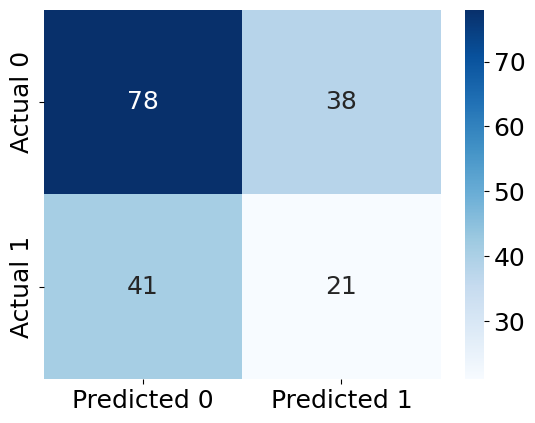

In [1143]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.31)

Accuracy increased, but so did FNR. Don't include height transformation.

# Testing Interactions

### Testing hair_loss

In [1144]:
train["hair_loss"].describe()

count    361.000000
mean       0.457064
std        0.498844
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: hair_loss, dtype: float64

In [1155]:
sub_loss = train[train.hair_loss > 0.457064]

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

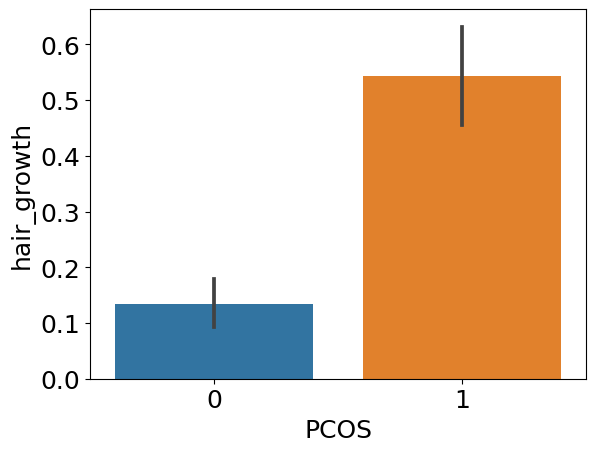

In [1156]:
sns.barplot(x = "PCOS", y = "hair_growth", data = train)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

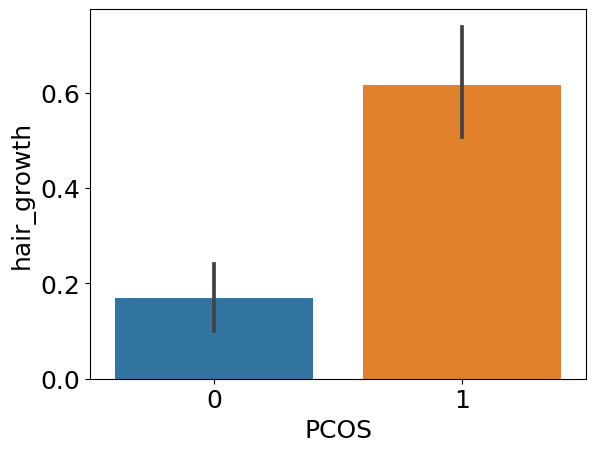

In [1157]:
sns.barplot(x = "PCOS", y = "hair_growth", data = sub_loss)

Consider adding regular_exercise*weight_gain

<AxesSubplot:xlabel='PCOS', ylabel='weight_gain'>

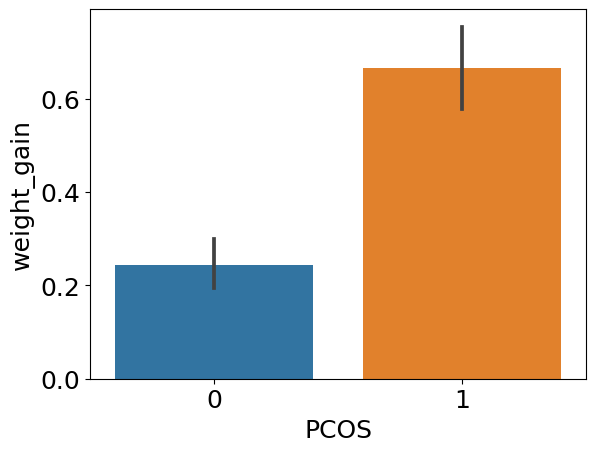

In [1239]:
sns.barplot(x = "PCOS", y = "weight_gain", data = train)

<AxesSubplot:xlabel='PCOS', ylabel='weight_gain'>

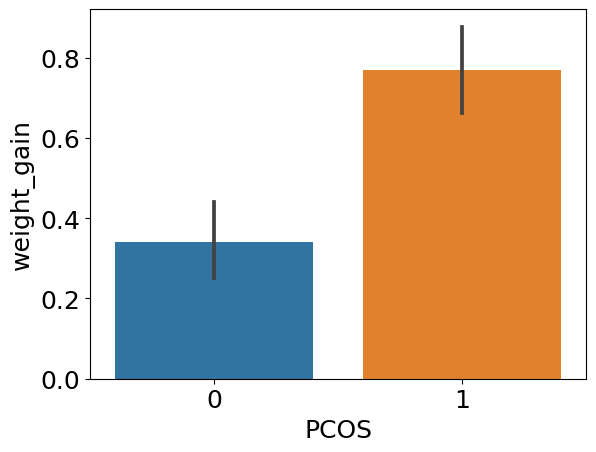

In [1240]:
sns.barplot(x = "PCOS", y = "weight_gain", data = sub_loss)

### Testing regular_exercise

In [1158]:
train["regular_exercise"].describe()

count    361.000000
mean       0.249307
std        0.433213
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: regular_exercise, dtype: float64

In [1159]:
sub_reg = train[train.regular_exercise > 0.249307]

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

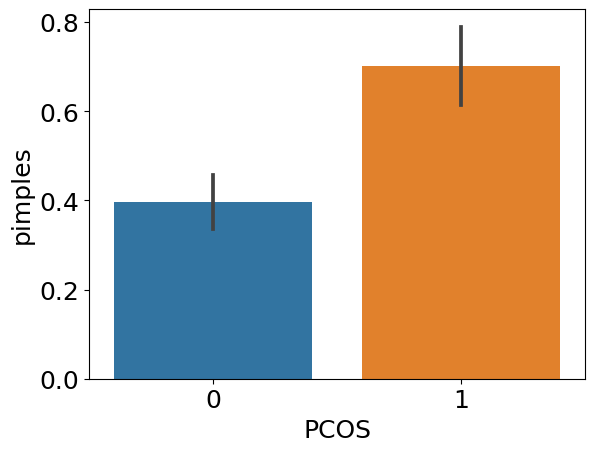

In [1160]:
sns.barplot(x = "PCOS", y = "pimples", data = train)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

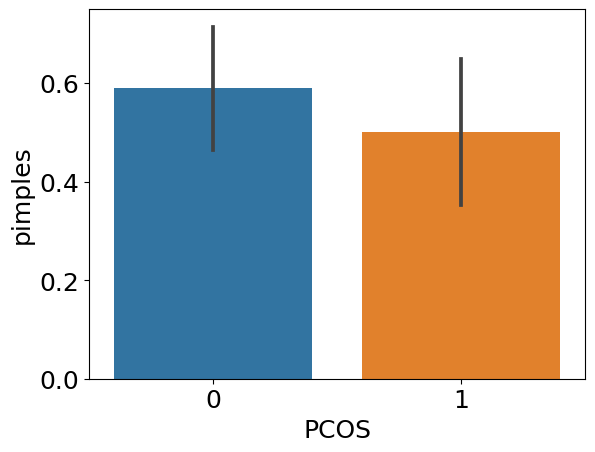

In [1161]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_reg)

Significant difference between pimples and PCOS with full train and subset of those who exercise regularly a lot. Include interaction regular_exercise*pimples.

## Correlation

<AxesSubplot:>

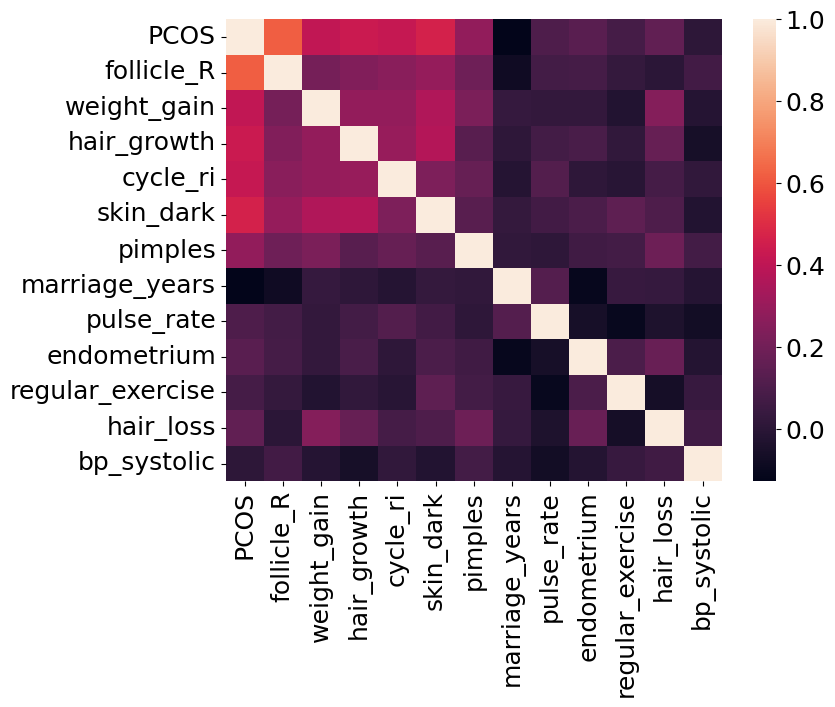

In [642]:
corrmat = forward_subset.corr()
plt.subplots(figsize=(8,6))
sns.heatmap(corrmat)

# Final Model

In [1271]:
baseline = sm.logit("PCOS ~ num + patient + age + BMI + blood_group + pulse_rate + RR + hb + cycle_ri + cycle + marriage_years + pregnant + number_abortions + I + FAH + LH + FSH_LH + hw_ratio + TSH + PRL + vit + prg + rbs + weight_gain + hair_growth + skin_dark + hair_loss + pimples + fast_food + regular_exercise + bp_systolic + bp_distolic + follicle_L + follicle_R + ave_size_L + ave_size_R", data = train).fit()


         Current function value: 0.183306
         Iterations: 35


Classification accuracy = 91.0468%
False Negative = 9.0909%
False Positive = 8.8154%


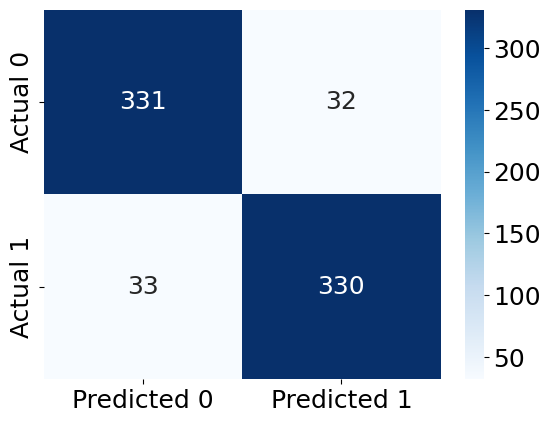

In [1344]:
confusion_matrix_test(test, test.PCOS, baseline, cutoff = 0.3)

### Final Model implementing forward selection, transformations, interactions

In [1338]:
final = sm.logit("PCOS ~ follicle_R + weight_gain + hair_growth + cycle_ri + skin_dark + pimples + marriage_years + + regular_exercise + fast_food + height + regular_exercise*pimples", data = train).fit()
final.summary()


Optimization terminated successfully.
         Current function value: 0.214435
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  539
Model:                          Logit   Df Residuals:                      527
Method:                           MLE   Df Model:                           11
Date:                Tue, 07 Mar 2023   Pseudo R-squ.:                  0.6605
Time:                        18:23:17   Log-Likelihood:                -115.58
converged:                       True   LL-Null:                       -340.48
Covariance Type:            nonrobust   LLR p-value:                 1.584e-89
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -7.0788      4.603     -1.538      0.124     -16.101       1.944
follicle_R                   0.5190      0.057      9.083      0.000       0.407       0.631
weight_gain                  1.4761      0.369      3.998      0.000       0.753       2.200
hair_growth                  1.7769      0.388      4.584      0.000       1.017       2.537
cycle_ri                     0.8317      0.187      4.449      0.000       0.465       1.198
skin_dark                    1.3347      0.380      3.511      0.000       0.590       2.080
pimples                      1.3571      0.426      3.187      0.001       0.523       2.192
marriage_years              -0.1024      0.039     -2.623      0.009      -0.179      -0.026
regular_exercise             1.4061      0.608      2.312      0.021       0.214       2.598
fast_food                    0.4717      0.368      1.281      0.200      -0.250       1.193
height                      -1.2272      2.891     -0.424      0.671      -6.894       4.439
regular_exercise:pimples    -1.2218      0.790     -1.547      0.122      -2.770       0.326
============================================================================================
"""

Classification accuracy = 91.1846%
False Negative = 7.9890%
False Positive = 9.6419%


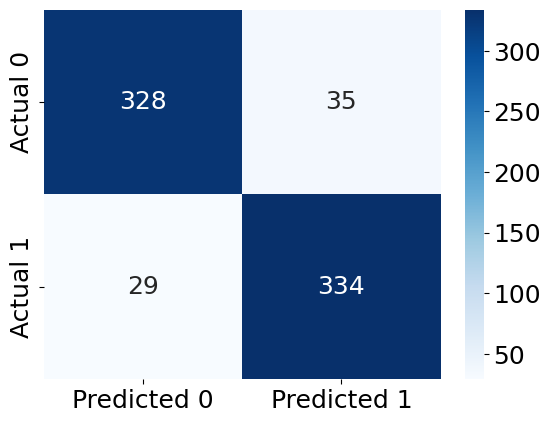

In [1346]:
confusion_matrix_test(test, test.PCOS, final, cutoff = 0.3)